<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/nice_movie_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import tensorflow as tf
import time
import numpy as np
import json

print(tf.__version__)

1.13.1


In [3]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [0]:
dataover = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_overview.csv",sep='#',lineterminator='\n')
taste = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_Jaime2.csv",sep=';', encoding='utf-8')
credits = pd.read_csv("gdrive/My Drive/TFG/tmdb_5000_credits.csv")

In [0]:
taste = taste[~taste['id'].str.contains('/')]
taste['id'] = taste['id'].astype(int)
credits['movie_id'] = credits['movie_id'].astype(int)

In [0]:
# Merge taste and credits

data = taste.merge(dataover[['id','overview']], left_on='id', right_on='id')
data = data.merge(credits[['movie_id','cast','crew']], left_on='id', right_on='movie_id')
data.drop(['movie_id'],axis=1, inplace= True)

In [76]:
data = data[~pd.isna(data.overview)]
len(data)

4406

In [77]:
data = data.dropna(subset=['like'])
data['like'] = data['like'].astype(int)
data.reset_index(inplace=True,drop=True)
len(data)

816

In [0]:
# Clean overviews ver que ocurre con deadpool y deadpool 2 

import string

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist() + ['secuela']

def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

def clean_overview(x):
    x = normalize(x.lower())
    x = x.translate(str.maketrans('','',string.punctuation))
    x = x.translate(str.maketrans('','','1234567890ªº'))
    return x

def delete_stop_words(x):
    words = x.split(" ")
    words = [word for word in words if word not in stop_words]
    x = str(' '.join(words))
    return x


In [0]:
data['overview']=data['overview'].apply(lambda x: clean_overview(str(x)))
data['overview']=data['overview'].apply(lambda x: delete_stop_words(x))

In [0]:
# Get staff and paste to overview

def get_actors(cast):
  
  try:
    
    json_cast = json.loads(cast)
  
  except:
    
    json_cast = cast
  
  if len(json_cast) > 2:
    up = 3
  else:
    up = len(json_cast)
   
  actors = ''
  for i in range(0,up):
    actor = json_cast[i]['name']
    actor = normalize(actor.replace(' ','_').lower())
  
    actors = actors + ' ' + actor
  
  return actors

def get_director(crew):
  
  try:
    
    json_crew = json.loads(crew)
  
  except:
    
    json_crew = crew
  
  directors = [member['name'] for member in json_crew if member['job'] == 'Director']
  directors = [normalize(director.replace(' ','_').lower()) for director in directors]
  directors = str(' '.join(directors))
  
  return directors

In [0]:
data['overview']=data.apply(lambda x: get_actors(x['cast']) + ' ' + x['overview'] , axis=1)
data['overview']=data.apply(lambda x: get_director(x['crew']) + x['overview'] , axis=1)

In [84]:
data['overview'][0]

'george_lucas mark_hamill harrison_ford carrie_fisher princesa leia lider movimiento rebelde desea reinstaurar republica galaxia tiempos ominosos imperio capturada malevolas fuerzas imperiales capitaneadas implacable darth vader sirviente fiel emperador intrepido luke skywalker ayudado capitan nave espacial halcon milenario androides rd cpo seran encargados luchar enemigo rescatar princesa volver instaurar justicia seno galaxia'

In [0]:
from sklearn.model_selection import train_test_split

overviews = data['overview'].values
y = data['like'].values

overviews_train, overviews_test, y_train, y_test = train_test_split(overviews, y, test_size=0.1, random_state=777, stratify=y)

In [0]:
columns_train = {'Overview': overviews_train, 'Like': y_train}
train = pd.DataFrame(data=columns_train)
train.to_csv('train' + '.csv', sep=';', encoding='utf-8', index=False)

columns_test = {'Comment': overviews_test, 'Like': y_test}
test = pd.DataFrame(data=columns_test)
test.to_csv('test' + '.csv', sep=';', encoding='utf-8', index=False)

In [0]:
# Embedding
num_words = 12000
maxlen = 90
embedding_size = 300

# Convolution
kernel_size = 5
filters = 250
pool_size = 2

hidden_dims = 250


# LSTM
lstm_output_size = 70

# Training
#lr=0.000005
lr=0.0001

In [94]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words) 
tokenizer.fit_on_texts(overviews_train)

X_train = tokenizer.texts_to_sequences(overviews_train) 
X_test = tokenizer.texts_to_sequences(overviews_test)

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index

print(overviews_train[2]) 
print(X_train[2]) 
print(vocab_size)

john_g._avildsen ralph_macchio pat_morita william_zabka daniel larusso llega angeles procedente costa unidos dispuesto amigos convierte blanco ataques cobras hostil grupo estudiantes karate comienza salir ali antigua novia cabecilla grupo situacion remedio pedirle ayuda miyagi maestro artes marciales enseñe karate tutela miyagi daniel desarrolla aptitudes fisicas seguridad necesita superar obstaculos
[4, 2329, 5374, 1062, 5375, 2330, 5376, 85, 5377, 223, 5378, 134, 417, 1308, 536, 78, 882, 15, 135, 303, 1704, 5379, 1063, 6, 376, 3284, 61, 418, 1309, 480, 71, 3285, 6, 177, 627, 2331, 20, 3286, 628, 2332, 2333, 2334, 3284, 5380, 3286, 223, 1705, 5381, 5382, 196, 377, 748, 2335]
12194


In [95]:
from collections import OrderedDict

dictWords = dict(tokenizer.word_counts)

print(len(dictWords) + 1)

for k,v in list(dictWords.items()):
    if v < 2 :
        del dictWords[k]
        
print(len(dictWords) + 1) 
# Para establecer el tamaño de maxlen

len(max(X_train, key=len))

12194
5351


91

In [96]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

X_train[1]

array([ 250, 5360,  302,  624,  625, 3279,  479, 5361, 5362, 3280, 5363,
       5364, 3281, 3282, 5365,   43, 3280, 5366,  251,    7, 5367,  252,
         31,  122, 2324, 1307,  880,  176,  151, 5368, 2325,  626, 5369,
       1702,  252, 2326,  416, 1703, 1061, 5370,   32, 2327, 3283, 5371,
        881,  252, 5372, 5373, 2328,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[0]
    K.get_session().run(tf.local_variables_initializer())
    return auc

#Optimizer

from tensorflow.keras import optimizers

adam = optimizers.Adam(lr)


es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=3,
                   verbose=0, mode='auto')

In [133]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weights

array([0.96578947, 1.03672316])

In [0]:
# Model 1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D

model = Sequential()

model.add(Embedding(vocab_size,embedding_size, input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['acc',precision,recall])

model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 2048)          22896640  
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               50100     
___________________________

In [157]:
# Model 2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(vocab_size,
                    embedding_size,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy',precision])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 90, 300)           3658200   
_________________________________________________________________
dropout_8 (Dropout)          (None, 90, 300)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 86, 250)           375250    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 250)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 250)               62750     
_________________________________________________________________
activation_16 (Activation)   (None, 250)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 251       
__________

In [158]:
history = model.fit(X_train, y_train,
                    epochs=15,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64, class_weight = class_weights)

Train on 734 samples, validate on 82 samples
Epoch 1/15
734/734 [==============================] - 1s 999us/sample - loss: 0.6943 - acc: 0.5177 - precision: 0.0500 - val_loss: 0.6927 - val_acc: 0.5122 - val_precision: 0.5752
Epoch 2/15
734/734 [==============================] - 0s 354us/sample - loss: 0.6720 - acc: 0.6512 - precision: 0.6188 - val_loss: 0.6893 - val_acc: 0.5610 - val_precision: 1.0000
Epoch 3/15
734/734 [==============================] - 0s 338us/sample - loss: 0.6372 - acc: 0.7793 - precision: 1.0000 - val_loss: 0.6841 - val_acc: 0.7073 - val_precision: 0.8810
Epoch 4/15
734/734 [==============================] - 0s 316us/sample - loss: 0.5757 - acc: 1.0000 - precision: 1.0000 - val_loss: 0.6750 - val_acc: 0.5366 - val_precision: 0.5000
Epoch 5/15
734/734 [==============================] - 0s 314us/sample - loss: 0.4753 - acc: 1.0000 - precision: 1.0000 - val_loss: 0.6543 - val_acc: 0.7805 - val_precision: 0.8762
Epoch 6/15
734/734 [==============================] - 0

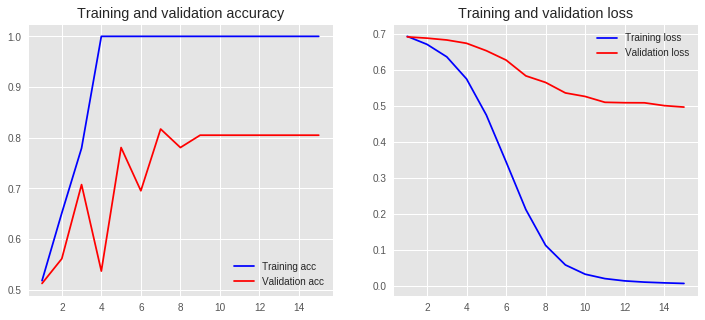

In [159]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [0]:
y_pred = model.predict_classes(X_test)
y_score = model.predict(X_test)
#y_pred= model.predict_classes(X_neutral)
#y_test = y_netural

for idx,p in enumerate(y_score):
    if p >= 0.50:
        y_pred[idx] = 1
    else:
        y_pred[idx] = 0

In [161]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Kappa: {:.4f}".format(cohen_kappa_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred,pos_label=1)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred,pos_label=1)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred,pos_label=1)))
print("Auc: {:.4f}".format(roc_auc_score(y_test, y_pred)))

Confusion Matrix: 
[[42  0]
 [16 24]]
Accuracy: 0.8049
Kappa: 0.6058
Precision: 1.0000
Recall: 0.6000
F1: 0.7500
Auc: 0.8000


In [0]:
model.save('nice_movie' + '_model2.h5')  

In [163]:
!pip install tmdbsimple

import tmdbsimple as tmdb

tmdb.API_KEY = '38dd5c6c01713ef99903275d51e2fd68'

In [0]:
def get_likeness(film):
  
  search = tmdb.Search()
  response = search.movie(query=film,language='es-ES')
  
  print(response)
  

  if len(response['results']) >= 1:
    over = response['results'][0]['overview']
    score = response['results'][0]['vote_average']
    
    id_movie = response['results'][0]['id']
    
    movie = tmdb.Movies(id_movie)
    
    actors = get_actors(movie.credits()['cast'])
    director = get_director(movie.credits()['crew'])
    
    over = clean_overview(str(over))
    over = delete_stop_words(over)

    over = actors + ' ' + over
    over = director + over
    
    print(over)
    
    X_over = tokenizer.texts_to_sequences(np.array([over]))
    X_over = pad_sequences(X_over, padding='post', maxlen=maxlen)

    probability = model.predict(X_over)
    print(probability)
    probability = probability[0][0] * 0.75 + (score/10)*0.25
    
    if (probability >= 0.5):
        pred = 1
        print(probability)
        if (probability < 0.5):
          probability = 0.5
        
    else:
        pred = 0
    
    return (str(pred) , str(probability), score/10)
  
  else:
    
    return 'No existe la peli'
  

In [219]:
movie = tmdb.Movies(64)
    
get_director(movie.credits()['crew'])

'pedro_almodovar'

In [281]:
get_likeness("deadpool 2")

{'page': 1, 'total_results': 2, 'total_pages': 1, 'results': [{'vote_count': 7966, 'id': 383498, 'video': False, 'vote_average': 7.5, 'title': 'Deadpool 2', 'popularity': 45.921, 'poster_path': '/jx3URmImNMCZuXcfdLM7S5Pivzy.jpg', 'original_language': 'en', 'original_title': 'Deadpool 2', 'genre_ids': [28, 35, 12], 'backdrop_path': '/3P52oz9HPQWxcwHOwxtyrVV1LKi.jpg', 'adult': False, 'overview': 'Wade Wilson (Ryan Reynolds), mejor conocido como Deadpool, su nombre de batalla e identidad antiheroica, está de regreso con Deadpool 2 y en esta ocasión su misión será salvar a un chico llamado Russell (Julian Dennison) de las manos de un poderoso rival llamado Cable (Josh Brolin). En aras de dar cumplimiento a su tarea el antihéroe formará un grupo al cual pondrá el nombre de X-Force. Secuela de la exitosa película (recaudó más de 780 millones de dólares en todo el mundo) parodia de los superhéroes mutantes del 2016, también protagonizada por Reynolds.', 'release_date': '2018-05-15'}, {'vote_c

('0', '0.4407936707139015', 0.75)

In [0]:
word_embds = model.layers[1].get_weights()[0]
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

In [0]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(word_embds)
number_of_words = 1000
trace = go.Scatter(
    x = X_embedded[0:number_of_words,0], 
    y = X_embedded[0:number_of_words, 1],
    mode = 'markers',
    text= word_list[0:number_of_words]
)
layout = dict(title= 't-SNE 1 vs t-SNE 2 for sirst 1000 words ',
              yaxis = dict(title='t-SNE 2'),
              xaxis = dict(title='t-SNE 1'),
              hovermode= 'closest')
fig = dict(data = [trace], layout= layout)
py.iplot(fig)

In [0]:
import xgboost as xgb

#model = xgb.XGBClassifier(max_depth=10,n_estimators=150,silent=False,objective='binary:logistic')
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)

In [0]:
!pip install finetune

In [0]:
from finetune import Classifier

model = Classifier()               # Load base model
model.fit(X_train, y_train)          # Finetune base model on custom data
y_pred = model.predict(X_test)